In [ ]:
!pip install gensim

In [ ]:
!python -m spacy download en_core_web_lg

**Imports**

In [ ]:
import gensim.downloader as api
import pandas as pd
import spacy
import numpy as np

**Importing nlp and word2vec models**

In [ ]:
wv = api.load('word2vec-google-news-300')
nlp = spacy.load('en_core_web_lg')

**Loading Data**

In [ ]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.tail()

,id,title,text,label
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


**Checking NuN Data**

In [ ]:
df.isnull().sum()

,0
id,0
title,0
text,0
label,0


**Converting classes numeric**

In [ ]:
df['news'] = df['label'].map({
    "FAKE": 0,
    "REAL":1
})

In [ ]:
df.head()

,id,title,text,label,news
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [ ]:
df['text'][0]

'Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. \nThe word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. \nBut that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. \nThe FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. \nThe FBI’s leadership is being warned that the entir

In [ ]:
df['label'][0]

'FAKE'

**Pre processing the text**

In [ ]:
def pre_process_text(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        # Skip unwanted tokens
        if token.is_stop or token.is_punct or token.is_space or token.like_num:
            continue
        # Optional: skip short, non-alphabetic or named entities
        if len(token.text) <= 2 or not token.lemma_.isalpha() or token.ent_type_ != "":
            continue
        filtered_tokens.append(token.lemma_.lower())
    # If no valid tokens found, return a zero vector (same dim as word2vec)
    if not filtered_tokens:
        return np.zeros(wv.vector_size)
    # Average word vectors of the tokens
    return np.mean([wv[token] for token in filtered_tokens if token in wv], axis=0)

**Text to vector**

In [ ]:
df['prcess_text'] = df['text'].apply(lambda text: pre_process_text(text))

**Train test splits**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.prcess_text.values,
    df.news,
    test_size=0.3,
    random_state=2025,
    stratify=df.news
)

**Converts vectors into a 2D NumPy array**

In [ ]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

**Scaling the data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

**Creating GradientBoostingClassifier Model**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
GBC = GradientBoostingClassifier()
GBC.fit(X_train_2d, y_train)

GradientBoostingClassifier()

**Creating MultinomialNB Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_2d, y_train)

MultinomialNB()

**Creating LogisticRegression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
LG = LogisticRegression()
LG.fit(X_train_2d, y_train)

LogisticRegression()

**Using custome text**

In [ ]:
text = pre_process_text(df['text'][0])
text = text.reshape(1, -1)

**Simple prediction**

In [ ]:
y_predict = GBC.predict(text)

**Prediction data visualization**

=== Classification Report: Gradient Boosting ===
              precision  recall  f1-score  support
0                  0.86    0.84      0.85   949.00
1                  0.85    0.86      0.85   952.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.85    0.85      0.85  1901.00
weighted avg       0.85    0.85      0.85  1901.00


=== Classification Report: Multinomial Naive Bayes ===
              precision  recall  f1-score  support
0                  0.73    0.75      0.74   949.00
1                  0.74    0.72      0.73   952.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.74    0.74      0.74  1901.00
weighted avg       0.74    0.74      0.74  1901.00


=== Classification Report: Logistic Regression ===
              precision  recall  f1-score  support
0                  0.87    0.84      0.85   949.00
1                  0.84    0.88      0.86   952.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.86  

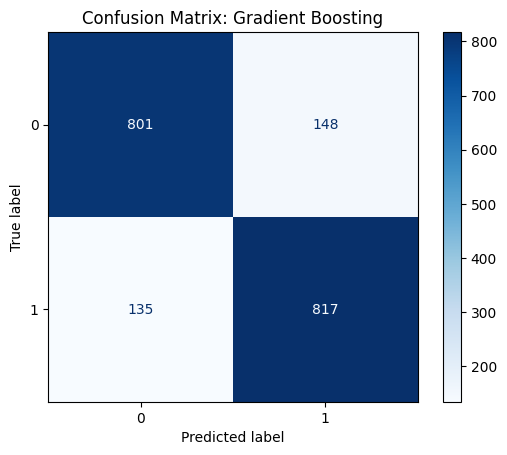

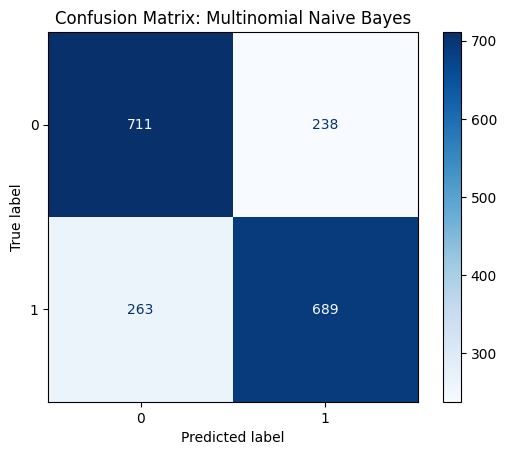

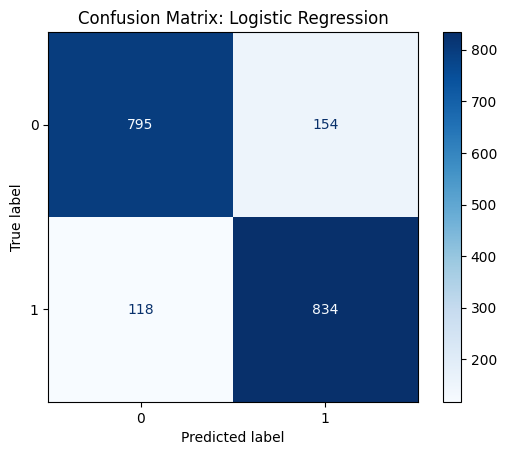

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define models
models = {
    "Gradient Boosting": GBC,
    "Multinomial Naive Bayes": mnb,
    "Logistic Regression": LG
}

reports = {}
confusion_matrices = {}

# Generate predictions, reports, and confusion matrices
for name, model in models.items():
    y_pred = model.predict(X_test_2d)
    reports[name] = classification_report(y_test, y_pred, output_dict=True)
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)

# --- Print classification reports ---
for name, report in reports.items():
    print(f"=== Classification Report: {name} ===")
    df_report = pd.DataFrame(report).transpose()
    print(df_report.round(2))
    print("\n" + "="*60 + "\n")

# --- Plot confusion matrices ---
for name, cm in confusion_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[name].classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.grid(False)
    plt.show()

# --- Optional: Compare F1-scores in bar chart ---
f1_scores = {
    name: report['weighted avg']['f1-score']
    for name, report in reports.items()
}



**Accuracies visualization**

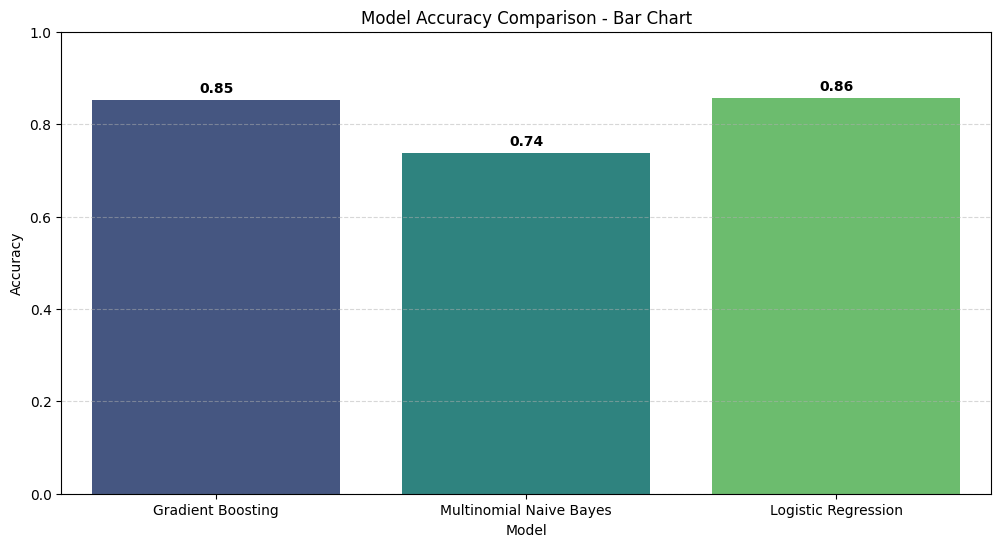

In [ ]:
# Prepare data as a DataFrame
import pandas as pd

acc_df = pd.DataFrame({
    'Model': list(accuracies.keys()),
    'Accuracy': list(accuracies.values())
})

# Use hue and disable legend to silence the warning
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=acc_df, x='Model', y='Accuracy', hue='Model', palette='viridis', legend=False)

plt.title("Model Accuracy Comparison - Bar Chart")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Add accuracy labels on top of bars
for i, row in acc_df.iterrows():
    plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.show()
